In [47]:
import numpy as np
import csv
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as Data
import torchvision

In [48]:
from sklearn.model_selection import train_test_split
 #首先，读取.CSV文件成矩阵的形式。
my_matrix = np.loadtxt(open("results.csv"),delimiter=",",skiprows=0)
#print(my_matrix)
 #对于矩阵而言，将矩阵倒数第一列之前的数值给了X（输入数据），将矩阵大最后一列的数值给了y（标签）
X, y = my_matrix[:,:-1],my_matrix[:,-1]
 #利用train_test_split方法，将X,y随机划分问，训练集（X_train），训练集标签（X_test），测试卷（y_train），
 #测试集标签（y_test），安训练集：测试集=7:3的
 #概率划分，到此步骤，可以直接对数据进行处理
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
 #此步骤，是为了将训练集与数据集的数据分别保存为CSV文件
 #np.column_stack将两个矩阵进行组合连接
train= np.column_stack((X_train,y_train))
 #numpy.savetxt 将txt文件保存为.csv结尾的文件
np.savetxt('train_usual.csv',train, delimiter = ',')
test = np.column_stack((X_test, y_test))
np.savetxt('test_usual.csv', test, delimiter = ',')

In [49]:
torch_x = torch.from_numpy(X_train)
torch_y = torch.from_numpy(y_train)
test_x = torch.from_numpy(X_test)
test_y = torch.from_numpy(y_test)
y_train = torch.tensor(torch_y, dtype=torch.long)
y_test = torch.tensor(test_y,dtype = torch.long)
x_test = torch.tensor(test_x , dtype=torch.float32)
x_train = torch.tensor(torch_x, dtype=torch.float32)



/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/ysx/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

In [121]:
#Hyper parameters
EPOCH = 20
BATCH_SIZE = 50
TIME_STEP = 20
INPUT_SIZE = 60
LR = 0.01

In [122]:
x_test = x_test.reshape(x_test.shape[0], TIME_STEP, INPUT_SIZE)
x_train = x_train.reshape(x_train.shape[0], TIME_STEP, INPUT_SIZE)
#print(x_train.shape,x_test.shape)
torch_dataset = Data.TensorDataset(x_train,y_train )
train_loader = Data.DataLoader(dataset= torch_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)
#print(x_train,x_test)

In [123]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=3,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 8)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

In [124]:
rnn =  RNN()
print(rnn)
optimizer = torch.optim.Adam(rnn.parameters(), lr = LR)
loss_func = torch.nn.CrossEntropyLoss()

RNN(
  (rnn): LSTM(60, 64, num_layers=3, batch_first=True)
  (out): Linear(in_features=64, out_features=8, bias=True)
)


In [125]:
Loss_RNN = []
Times = []
times = 0
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x.view(-1,TIME_STEP,INPUT_SIZE))   # batch x
        b_y = Variable(y)   # batch y
        
        output = rnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        Loss_RNN.append(loss.data)
        times += 1
        Times.append(times)
        
        if step % 50 == 0:
            train_output = rnn(x_train)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            train_accuracy = (pred_y == y_train).sum().item() / float(y_train.size(0))
            test_output = rnn(x_test)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            test_accuracy = (pred_y == y_test).sum().item() / float(y_test.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data,'| train accuracy: %.2f' % train_accuracy, '| test accuracy: %.2f' % test_accuracy)
        
        
        

Epoch:  0 | train loss: 2.0791 | train accuracy: 0.23 | test accuracy: 0.21
Epoch:  1 | train loss: 2.0559 | train accuracy: 0.13 | test accuracy: 0.13
Epoch:  2 | train loss: 1.9696 | train accuracy: 0.17 | test accuracy: 0.15
Epoch:  3 | train loss: 2.5240 | train accuracy: 0.37 | test accuracy: 0.38
Epoch:  4 | train loss: 1.7265 | train accuracy: 0.42 | test accuracy: 0.45
Epoch:  5 | train loss: 1.2009 | train accuracy: 0.60 | test accuracy: 0.58
Epoch:  6 | train loss: 0.7511 | train accuracy: 0.67 | test accuracy: 0.67
Epoch:  7 | train loss: 0.5548 | train accuracy: 0.79 | test accuracy: 0.78
Epoch:  8 | train loss: 0.6626 | train accuracy: 0.85 | test accuracy: 0.78
Epoch:  9 | train loss: 0.4428 | train accuracy: 0.84 | test accuracy: 0.82
Epoch:  10 | train loss: 0.3202 | train accuracy: 0.87 | test accuracy: 0.85
Epoch:  11 | train loss: 0.2346 | train accuracy: 0.89 | test accuracy: 0.87
Epoch:  12 | train loss: 0.1853 | train accuracy: 0.95 | test accuracy: 0.92
Epoch:  1

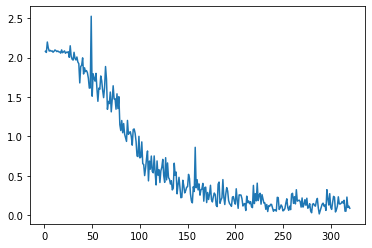

In [131]:
plt.plot(Times,Loss_RNN)
plt.show()
np.save('Loss_RNN.npy', Loss_RNN)

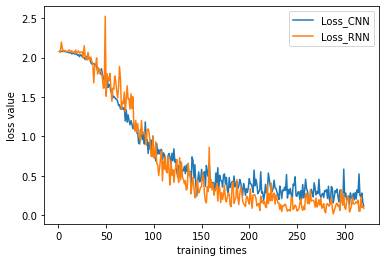

In [139]:
Loss_CNN = np.load('Loss_CNN.npy')
#print(Loss_CNN)
plt.plot(Times,Loss_CNN,label = 'Loss_CNN')
plt.plot(Times,Loss_RNN,label = 'Loss_RNN')
plt.xlabel('training times')
plt.ylabel('loss value')
#plt.title('')
plt.legend()
plt.savefig('Loss.tif', dpi = 400)

plt.show()


In [147]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

In [148]:
# 预测数据，predict之后的预测结果集
guess = pred_y.numpy()
# 真实结果集
fact = y_test.numpy()
# 类别
classes = list(set(fact))
# 排序，准确对上分类结果
classes.sort()
# 对比，得到混淆矩阵
confusion = confusion_matrix(guess, fact)



In [149]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
print(accuracy_score(fact,guess),recall_score(fact, guess,average='macro'))

0.9619883040935673 0.9618389469608981


In [152]:
acc = float(accuracy_score(fact,guess))
recall = float(recall_score(fact, guess,average='macro'))


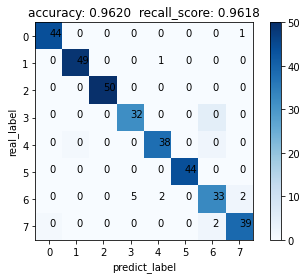

In [155]:
# 热度图，后面是指定的颜色块，gray也可以，gray_x反色也可以
plt.imshow(confusion, cmap=plt.cm.Blues)
# 这个东西就要注意了
# ticks 这个是坐标轴上的坐标点
# label 这个是坐标轴的注释说明
indices = range(len(confusion))
# 坐标位置放入
# 第一个是迭代对象，表示坐标的顺序
# 第二个是坐标显示的数值的数组，第一个表示的其实就是坐标显示数字数组的index，但是记住必须是迭代对象
plt.xticks(indices, classes)
plt.yticks(indices, classes)
# 热度显示仪？就是旁边的那个验孕棒啦
plt.colorbar()
# 就是坐标轴含义说明了
plt.xlabel('predict_label')
plt.ylabel('real_label')
plt.title('accuracy: 0.9620  recall_score: 0.9618')
# 显示数据，直观些
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
plt.savefig('RNN_results.tif', dpi = 400)
plt.show()